##Report points:
1. chosen dataset and which parts of it were used: only article and language columns (no date and site) and news in English only because it is useless to consider articles written in different languages together, so languages that are supported by NLTK and that we personally know
2. organization of data: RDD with 2 columns in 4 partitions (control if 4 partitions is ok in Google Colab)
3. pre-processing: selecting only language of interest, removing punctuation and stopwords, tokenizing the text (bag-of-words)
4. algorithms: Apriori, Toivonen

##Import authorization token previously downloaded from Kaggle

In [ ]:
# upload token file kaggle.json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davideriva","key":"944a9991fe50dd19c5285280a9796ad0"}'}

In [ ]:
# move the token file to the ./kaggle directory

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

##Access Kaggle API, download the "Old Newspapers" dataset and unzip it


In [ ]:
# authenticate to the Kaggle API

import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
# download and unzip "Old Newspapers" dataset

import zipfile

api.dataset_download_file("alvations/old-newspapers", file_name="old-newspaper.tsv", path="./")

with zipfile.ZipFile('old-newspaper.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

##Initialize a SparkContext object and create the RDD

In [ ]:
# check number of available cores

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
# initialize a SparkContext object 

! pip install pyspark

import pyspark
sc = pyspark.SparkContext()

     |████████████████████████████████| 212.3MB 65kB/s 
     |████████████████████████████████| 204kB 39.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=dd518260f65e2d2cd8d0c9992c966c18e653a8baa104f9c588d1c9c7497dca2c
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
# create an RDD from the "Old Newspapers" dataset and display the first instance

newsRDD = sc.textFile("old-newspaper.tsv", 2)
newsRDD.take(1)

['Language\tSource\tDate\tText']

##Preprocessing

In [ ]:
# define function to split elements of a row

def split_row(x):

  tup = x.split('''\t''')
  
  date = tup[2]
  year = date[:4]  

  return (tup[0], year, tup[3])

In [ ]:
subRDD = newsRDD.map(split_row)
subRDD.take(1)

[('Language', 'Date', 'Text')]

In [ ]:
# count by years

subRDD.map(lambda t: t[1]).countByValue()

defaultdict(int,
            {'1970': 6,
             '2000': 6075,
             '2001': 7811,
             '2002': 6183,
             '2003': 8452,
             '2004': 20091,
             '2005': 77733,
             '2006': 169678,
             '2007': 369179,
             '2008': 687741,
             '2009': 1494895,
             '2010': 3207680,
             '2011': 7247763,
             '2012': 2812367,
             '2013': 380469,
             'Date': 1,
             'UNKN': 309918})

In [ ]:
# look directly at those with year = 'Date' or year = '1970'

subRDD.filter(lambda t: t[1]=='Date' or t[1]=='1970') \
      .collect()

[('French',
  '1970',
  'La paire avait inscrit 12 buts en quatre mois. La marche semble haute pour les néo-Auxerrois. Comme pour Jelen.'),
 ('French', '1970', 'Les promesses de Fall'),
 ('French',
  '1970',
  "Ce que l'on sait, d'ores-et-déjà, c'est que Jelen (en fin de contrat en juin) a peu de chances d'en faire partie. La tendance de l'hiver ne sera peut-être pas celle de l'été, certes. Mais il y a quelques jours, Jean Fernandez s'était montré plutôt catégorique : « Jelen partira en fin de saison »."),
 ('Language', 'Date', 'Text'),
 ('French',
  '1970',
  "Habitué depuis deux ans à faire venir des attaquants au mercato hivernal (Quercia en 2008 et Birsa en 2009), Jean Fernandez justifie les arrivées de Jo-Gook et Fall comme des choix « d'avenir ». Et éclaire sur la capacité de ces joueurs à réussir à court terme. « L'expérience me fait dire qu'il y a plus d'échecs que de réussite au mercato d'hiver. Lorsque j'étais à Marseille, Maoulida et Pagis avaient été de bonnes recrues »."),

In [ ]:
# look at the language in which the ones with unknown date were written

subRDD.filter(lambda t: t[1]=='UNKN') \
      .map(lambda t: t[0]) \
      .countByValue()  # all in Spanish

defaultdict(int, {'Spanish': 309918})

In [ ]:
# we wont consider news in Spanish and French, so we can forget about anomalous year values
# build English RDD and count how many articles for English
# to repeat the whole process for any other language (we did it for Italian), just substitute the language here

textRDD = subRDD.filter(lambda x: x[0]=='English')

In [ ]:
textRDD.take(5)

[('English', '2012', "He wasn't home alone, apparently."),
 ('English',
  '2011',
  'The St. Louis plant had to close. It would die of old age. Workers had been making cars there since the onset of mass automotive production in the 1920s.'),
 ('English',
  '2012',
  "WSU's plans quickly became a hot topic on local online sites. Though most people applauded plans for the new biomedical center, many deplored the potential loss of the building."),
 ('English',
  '2011',
  'The Alaimo Group of Mount Holly was up for a contract last fall to evaluate and suggest improvements to Trenton Water Works. But campaign finance records released this week show the two employees donated a total of $4,500 to the political action committee (PAC) Partners for Progress in early June. Partners for Progress reported it gave more than $10,000 in both direct and in-kind contributions to Mayor Tony Mack in the two weeks leading up to his victory in the mayoral runoff election June 15.'),
 ('English',
  '2011',


In [ ]:
textRDD = textRDD.sample(withReplacement = False, fraction = 0.1, seed = 1262).repartition(2)                 ### FOR TESTING PURPOSES

In [ ]:
N = textRDD.count()
N

100933

In [ ]:
# define a function to tokenize and lemmatize news

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from nltk.corpus import stopwords

from numpy import unique
from string import punctuation

def preprocess(tup):

  ### ARGS
  # tup = (language, date, text)

  ### OUTPUT
  # list of lemmatized tokens in the text field

  ### REQUIRES
  # libraries: nltk, re, numpy.unique, string.punctuation
  # modules (nltk): stopwords, punkt, wordnet 

  if tup[0] == 'English':
    sw = stopwords.words("english") + list(punctuation) + ["n't", "'m", "'d", "'re", "'s","'ve", "'ll", '``', "''", "--", '“', '’','”','...',"«", "»", "–"]
  else:
    sw = stopwords.words("italian") + list(punctuation) + ["«", "»", "–",'``', "''", "--", '“', '’','”','...']

  text = re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', tup[2])

  lemmatizer = nltk.WordNetLemmatizer()
  tokenized_text = nltk.word_tokenize(text.lower())
  tokenized_text = list(unique(tokenized_text))

  return [lemmatizer.lemmatize(w) for w in tokenized_text if w not in sw]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# apply preprocessing and remove eventually empty bags-of-words
### WARNING: TO BE RUN TWICE
# don't understand why the first time it doesn't work, while the second time it does

text_tokenized = textRDD.map(preprocess)
text_tokenized = text_tokenized.filter(lambda bow: len(bow) > 0)
N = text_tokenized.count()
N

100897

In [ ]:
# example

textRDD.take(1), text_tokenized.take(1)

([('English',
   '2009',
   '"""I kept pitching like it was a one-run game,"" he said. ""I never even looked at the scoreboard."""')],
 [['even',
   'game',
   'kept',
   'like',
   'looked',
   'never',
   'onerun',
   'pitching',
   'said',
   'scoreboard']])

Draw histogram of bag-of-words length

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Histogram of bag-of-words lengths')

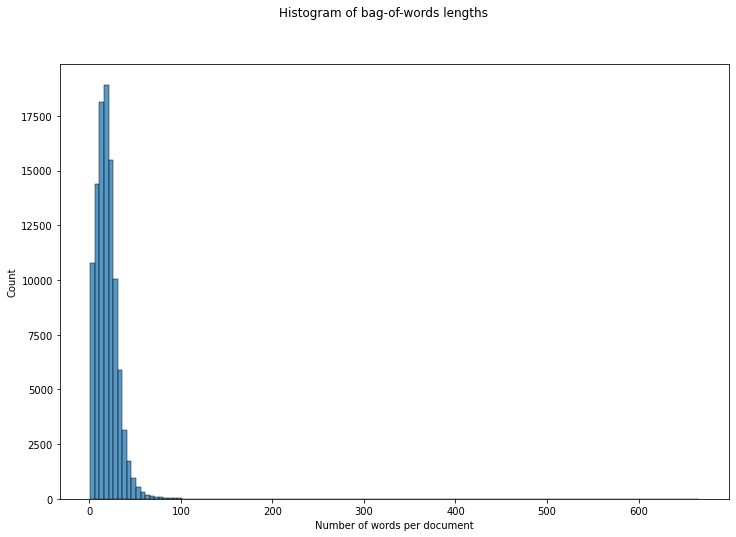

In [ ]:
lengths = text_tokenized.map(len) \
                       .collect()

f, ax = plt.subplots(figsize = (12,8))
sns.histplot(data = lengths, binwidth = 5, ax = ax)
ax.set_xlabel("Number of words per document")
f.suptitle("Histogram of bag-of-words lengths")


##A-Priori Algorithm


In [ ]:
# SINGLETONS
# define function to iteratively sum counters of equal words

def sumcum(x,y):
  return x+y

In [ ]:
import itertools

### Threshold = 0.01

In [ ]:
threshold = 0.01

In [ ]:
#eng counters

freq_items = text_tokenized.flatMap(lambda bow: [(word, 1) for word in bow]) \
                                 .reduceByKey(sumcum) \
                                 .filter(lambda t: t[1] >= threshold*N) \
                                 .collect()

In [ ]:
#eng singletons
freq_singletons = list(map(lambda x: x[0], freq_items))

In [ ]:
counters_1perc = []
counters_1perc.append(len(freq_singletons))

In [ ]:
candidates = list(itertools.combinations(freq_singletons, 2))
candidates = list(map(set, candidates))

In [ ]:
### FIND CANDIDATE ITEMSETS IN THE ROWS OF RDD: PLAN A

def candidate_combinations(bow, candidates):

  return [(tuple(c), 1) for c in candidates if c.issubset(set(bow))]

In [ ]:
### FIND CANDIDATE ITEMSETS IN THE ROWS OF RDD: PLAN B

from numpy import searchsorted

def find_in_bow(candidates, bow):

  output = []

  for itemset in candidates:
    for item in itemset:
      x = searchsorted(bow, item)
      if (x >= len(bow) or bow[x] != item):
        break
    else:
      output.append((itemset, 1))

  return output

In [ ]:
### FIND CANDIDATE ITEMSETS IN THE ROWS OF RDD: PLAN C

# requires candidates to be all of equal length

def candidates_with_itertools(bow, candidates):

  K = len(candidates[0])

  combos = list(itertools.combinations(bow, K))

  combos = list(filter(lambda c: set(c) in candidates, combos))

  combos = list(map(lambda c: (c,1), combos))

  return combos

In [ ]:
# testing which function is the fastest

from time import time

testbows = text_tokenized.takeSample(withReplacement = False, num = 100, seed = 1262)

start = time()
[candidate_combinations(bow, candidates) for bow in testbows]
time_cc = time() - start

start = time()
[find_in_bow(candidates, bow) for bow in testbows]
time_fib = time() - start

start = time()
[candidates_with_itertools(bow, candidates) for bow in testbows]
time_cwi = time() - start

time_cc, time_fib, time_cwi       

In [ ]:
#eng frequent pairs - it takes 35min for running
new_freq_itemsets = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
#eng pairs with counters
old_freq_itemsets = list(map(lambda x: x[0], new_freq_itemsets))

In [ ]:
#length frequent eng pairs
counters_1perc.append(len(old_freq_itemsets))

In [ ]:
### FIND CANDIDATE ITEMSETS OF CARDINALITY K GIVEN FREQUENT ITEMSETS OF CARDINALITY K-1, FOR K > 2
# we don't need all combinations of elements of frequent itemsets,
# but itemsets whose immediate subsets are ALL frequent
# the next function is to be used for K > 2, whereas for K = 2 we may simply use itertools.combinations()

def find_candidate_itemsets(old_freq_itemsets, K):

  ### ARGS
  # old_freq_itemsets --> list of itemsets that were found to be frequent in previous pass
  # K --> cardinality of new candidate itemsets

  ### OUTPUT
  # list of candidate itemsets, as sets

  ### REQUIRES
  # libraries: itertools

  candidates = []

  for comb in list(itertools.combinations(old_freq_itemsets, K)):               # for each combination of K itemsets, e.g. [('a','b'),('c','a'),('b','c')]
    cand = set().union(*comb)                                                   # define the union set, e.g. {'a','b','c'}
    if len(cand) == K:
      candidates.append(cand)                                                   # and let the union be a candidate itemset if its cardinality is K

  return candidates                                                             # returns list of sets

In [ ]:
candidates = find_candidate_itemsets(old_freq_itemsets, K = 3)
new_freq_itemsets3 = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
len(new_freq_itemsets3)

0

In [ ]:
counters_1perc

[251, 20]

### Threshold = 0.02

In [ ]:
threshold = 0.02

In [ ]:
# sum all counters to obtain singleton counts

freq_items = text_tokenized.flatMap(lambda bow: [(word, 1) for word in bow]) \
                                 .reduceByKey(sumcum) \
                                 .filter(lambda t: t[1] >= threshold*N) \
                                 .collect()


In [ ]:
# filters the counters exceeding the threshold

freq_singletons = list(map(lambda x: x[0], freq_items))

In [ ]:
#computing the length of frequent singletons in english

counters_2perc = []

counters_2perc.append(len(freq_singletons))

Which are the frequent singletons, weighted by their frequency?

In [ ]:
#importing the libraries for depicting the wordcloud

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
#defining a function for converting lists into strings

def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [ ]:
#converting the list of freq_singletons in strings

string = convert_list_to_string(freq_singletons)

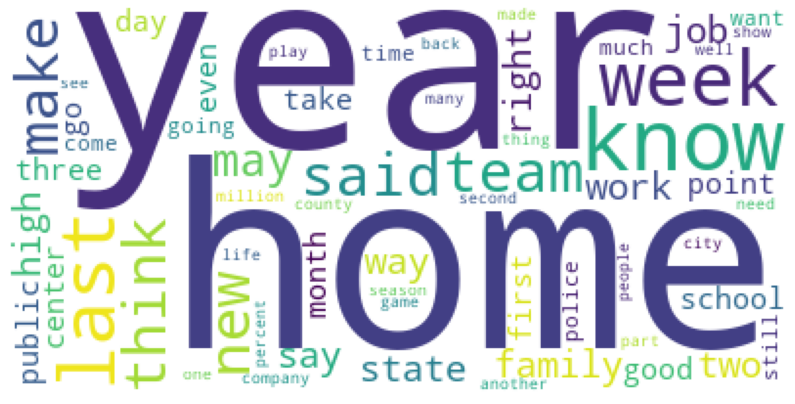

In [ ]:
#defining the worldcloud

wordcloud = WordCloud(background_color = "white").generate(string)

# displaying the wordcloud

plt.figure(figsize = (14, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# it might be different each time due to sampling

------------------------------------------

Now we turn to itemsets of cardinality > 1

In [ ]:
candidates = list(itertools.combinations(freq_singletons, 2))
candidates = list(map(set, candidates))

In [ ]:
# use candidate_combinations to count occurrences of candidates in the RDD -35 minutes to run

new_freq_itemsets = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
# check the lenghts of the list containing the frequent pairs

counters_2perc.append(len(new_freq_itemsets))                                   # needless to go futher, since also for threshold = 1% there were no triplets

In [ ]:
counters_2perc

[68, 2]

------------------------------------------

### Threshold = 0.03



In [ ]:
threshold = 0.03

In [ ]:
freq_items = text_tokenized.flatMap(lambda bow: [(word, 1) for word in bow]) \
                                 .reduceByKey(sumcum) \
                                 .filter(lambda t: t[1] >= threshold*N) \
                                 .collect()

In [ ]:
freq_singletons = list(map(lambda x: x[0], freq_items))

In [ ]:
counters_3perc = []

counters_3perc.append(len(freq_singletons))

In [ ]:
new_freq_itemsets = text_tokenized.flatMap(lambda bow: candidate_combinations(bow, candidates)) \
                       .reduceByKey(sumcum) \
                       .filter(lambda t: t[1] >= threshold*N) \
                       .collect()

In [ ]:
old_freq_itemsets = list(map(lambda x: x[0], new_freq_itemsets))

In [ ]:
counters_3perc.append(len(old_freq_itemsets))

In [ ]:
counters_3perc

[27, 0]

### Plot of counters of frequent itemsets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
counters_per_threshold = [counters_1perc, counters_2perc, counters_3perc]

counters_per_threshold = pd.DataFrame(counters_per_threshold)
counters_per_threshold.columns = ['1','2']
counters_per_threshold['thresholds'] = [0.01, 0.02, 0.03]

Text(0.5, 0.98, 'Counts of frequent itemsets per threshold')

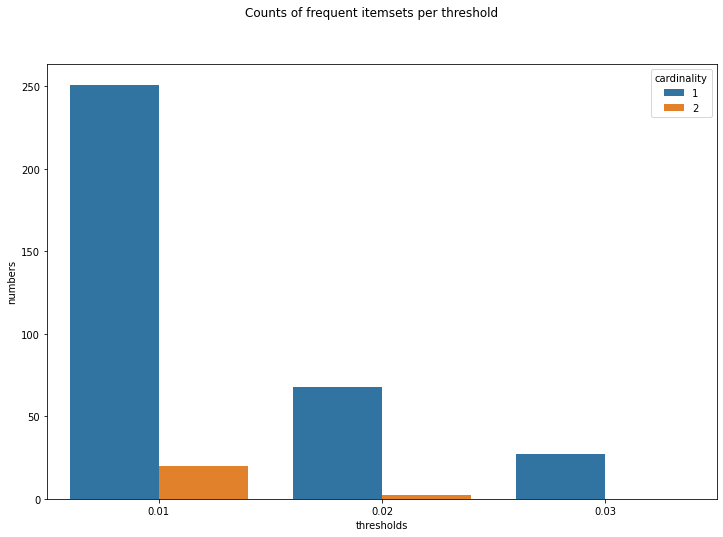

In [ ]:
df = pd.melt(counters_per_threshold, id_vars="thresholds", var_name="cardinality", value_name="numbers")

f, ax = plt.subplots(figsize = (12,8))
sns.barplot(x = 'thresholds', y = 'numbers', hue = 'cardinality', data = df, ax = ax)
f.suptitle("Counts of frequent itemsets per threshold")

## A-Priori Algorithm in a single function

In [ ]:
import itertools

def find_candidate_itemsets(old_freq_itemsets, K):

  ### ARGS
  # old_freq_itemsets --> list of itemsets that were found to be frequent in previous pass
  # K --> cardinality of new candidate itemsets

  ### OUTPUT
  # list of candidate itemsets, as sets

  ### REQUIRES
  # libraries: itertools

  candidates = []

  for comb in list(itertools.combinations(old_freq_itemsets, K)):               # for each combination of K itemsets, e.g. [('a','b'),('c','a'),('b','c')]
    cand = set().union(*comb)                                                   # define the union set, e.g. {'a','b','c'}
    if len(cand) == K:
      candidates.append(cand)                                                   # and let the union be a candidate itemset if its cardinality is K

  return candidates 

def sumcum(x,y):
  return x+y

In [ ]:
def a_priori(rdd, threshold):

  ### ARGS
  # rdd --> a PySpark RDD, each basket is a list of words
  # threshold --> the number of baskets above which an itemset is considered frequent, here it is not a percentage

  ### OUTPUT
  # the list of frequent itemsets

  ### REQUIRES
  # functions: sumcum, find_candidate_itemsets
  # libraries: itertools, pyspark
  
  rdd.cache()

  # sum all counters to obtain singleton counts
  freq_itemsets = rdd.flatMap(lambda bow: [(word, 1) for word in bow]) \
                     .reduceByKey(sumcum) \
                     .filter(lambda count: count[1] > threshold) \
                     .collect()

  # filters the counters exceeding the threshold
  freq_singletons = list(map(lambda x: x[0], freq_itemsets))

  # find candidate pairs using itertools.combinations()
  candidates = list(itertools.combinations(freq_singletons, 2))
  candidates = list(map(set, candidates))


  K = 3

  while len(candidates) > 0:

    # find the candidates in the baskets and count them
    new_freq_itemsets = rdd.flatMap(lambda bow: [(tuple(c), 1) for c in candidates if c.issubset(set(bow))]) \
                           .reduceByKey(sumcum) \
                           .filter(lambda count: count[1] >= threshold) \
                           .collect()



    # update the output
    freq_itemsets += new_freq_itemsets

    # assigns newly found frequent itemsets
    old_freq_itemsets = list(map(lambda x: x[0], new_freq_itemsets))

    # new candidates
    candidates = find_candidate_itemsets(old_freq_itemsets, K)
    
    K += 1

  rdd.unpersist()

  return freq_itemsets

Plot the time it takes to run the algorithm with a fixed threshold but different size of the dataset to prove scalability

In [ ]:
from time import time

In [ ]:
# try with different size of the dataset to prove scalability

sizes = [0.05, 0.1, 0.25, 0.5, 1]  # sizes are approx. 5000, 10000, 25000, 50000, 100000 for the English dataset
durations = []

for s in sizes:
  
  sampled_data = text_tokenized.sample(withReplacement = False, fraction = s)
  start = time()
  a_priori(sampled_data, 0.01*s*N)
  durations.append(time()-start)


In [ ]:
durations

[150.4057731628418,
 224.11750507354736,
 332.947110414505,
 1118.2760603427887,
 2078.3568794727325]

Text(0, 0.5, 'Time (seconds)')

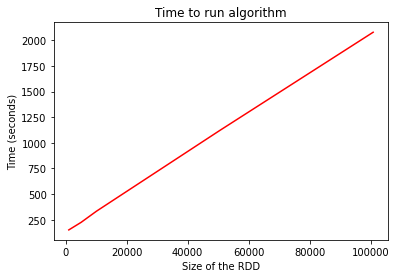

In [ ]:
plt.plot([N*size for size in sizes], durations, 'r-')
plt.title("Time to run algorithm")
plt.xlabel("Size of the RDD")
plt.ylabel("Time (seconds)")

--------------------------------------------------------

## Toivonen Algorithm 

Since the code risks running for too long (possibly indefinitely)due to the sampling, we will look at the frequent itemsets which are not found in the samples, in order to measure inaccuracy of running the A-Priori algorithm (chosen as underlying algorithm) on a sample rather than on the entire dataset. 
We will use several sampling percentages, the expected result is: the higher the size of the sample, the lower the number of missing itemsets.

In [ ]:
import itertools

def find_candidate_itemsets(old_freq_itemsets, K):

  ### ARGS
  # old_freq_itemsets --> list of itemsets that were found to be frequent in previous pass
  # K --> cardinality of new candidate itemsets

  ### OUTPUT
  # list of candidate itemsets, as sets

  ### REQUIRES
  # libraries: itertools

  candidates = []

  for comb in list(itertools.combinations(old_freq_itemsets, K)):               # for each combination of K itemsets, e.g. [('a','b'),('c','a'),('b','c')]
    cand = set().union(*comb)                                                   # define the union set, e.g. {'a','b','c'}
    if len(cand) == K:
      candidates.append(cand)                                                   # and let the union be a candidate itemset if its cardinality is K

  return candidates 

def sumcum(x,y):
  return x+y

In [ ]:
# change threshold here, we tested 0.01, 0.02, 0.03

threshold = 0.03
N = text_tokenized.count()

In [ ]:
# first, we need to sample p% baskets (bags-of-words)
# we can collect the sampled dataset if it is much smaller than the original one
# change p here to use different sampling percentages, we chose 5%, 10%, 15%

p = 0.05

sampled_data = text_tokenized.sample(withReplacement = False, fraction = p, seed = 1407) \
                           .collect()

# define a threshold slightly lower than the global one
local_threshold = 0.999*threshold                                               # threshold here is a percentage, so no need to multiply by p

In [ ]:
# use built-in A-Priori as algorithm for each pass

! pip install apyori

from apyori import apriori

  Created wheel for apyori: filename=apyori-1.1.2-cp37-none-any.whl size=5975 sha256=094407dec7cd93e3034745fbf8e80afaf926bf29cb361de477bebbd59d598eca
  Stored in directory: /root/.cache/pip/wheels/5d/92/bb/474bbadbc8c0062b9eb168f69982a0443263f8ab1711a8cad0
Successfully built apyori


In [ ]:
sample_freq_itemsets = list(apriori(sampled_data, min_support = local_threshold))
sample_freq_itemsets = [list(sample_freq_itemsets[i][0]) for i in range(0,len(sample_freq_itemsets))]

In [ ]:
# build the negative border by finding all itemsets that are not frequent in the sample,
# but whose immediate subsets are frequent in it
# we can use the already defined function find_candidate_itemsets

k = 1
nb = []
freq_k_itemsets = list(filter(lambda x: len(x) == 1, sample_freq_itemsets))
checklist = list(map(set, sample_freq_itemsets))

while len(freq_k_itemsets) > 0:
  
  nb_candidates = find_candidate_itemsets(freq_k_itemsets, k+1)
  checklist_k1 = list(filter(lambda x: len(x) == k+1, checklist))
  nb_candidates = list(filter(lambda x: x not in checklist, nb_candidates))
  nb += nb_candidates

  k += 1
  freq_k_itemsets = list(filter(lambda x: len(x) == k, sample_freq_itemsets))

In [ ]:
# verifying if the items belonging to the negative border are frequent in the eng_tokenized
trial = text_tokenized.flatMap(lambda bow: [(tuple(c), 1) for c in nb if c.issubset(set(bow))]) \
                     .reduceByKey(sumcum) \
                     .filter(lambda t: t[1] >= threshold*N) \
                     .collect()

# to complete the algorithm, we would need to restart from the sampling if the condition len(trial) > 0 is satisfied

KeyboardInterrupt: ignored

In [ ]:
len(trial), trial